In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import uproot, glob, time
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [2]:
path_to_reduced = '/p/lustre1/jacopod/31th/'
!ls $path_to_reduced

20201023_DS04_BkgData_1200ADCThreshold	20201101_DS22_Xe127Data
20201024_DS06_Xe127Data			20201102_DS23_NoiseData
20201025_DS08_Xe127Data			20201102_DS24_Rn220Data
20201026_DS09_Xe127Data			20201103_DS25_Run220Data
20201026_DS10_Xe127Data			20201103_DS26_Run220Data
20201027_DS12_Xe127Data			20201104_DS27_Run220Data
20201030_DS15_Xe127Data			20201105_DS28_Rn220Data
20201031_DS16_Xe127Data			20201106_DS29_Rn220Data
20201031_DS17_Xe127Data			20201107_DS30_Rn220Data
20201031_DS18_Xe127Data			config


In [9]:
folder = '20201107_DS30_Rn220Data/analysis_500ns'
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/31th/Run_Parameters_Run30.xlsx',\
                                         folder.split('/')[0])
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
df = pd.read_pickle(path_to_reduced + folder + '/reduced_added.p')
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 1-4 T20
SiPM 1-4 T5
SiPM 1-4 T80
SiPM 1-4 T90
SiPM 2-1 Baseline
SiPM 2-1 Baseline RMS
SiPM 2-1 Induced Charge
SiPM 2-1 Pulse Area
SiPM 2-1 Pulse Height
SiPM 2-1 Pulse Time
SiPM 2-1 T10
SiPM 2-1 T20
SiPM 2-1 T5
SiPM 2-1 T80
SiPM 2-1 T90


In [10]:
def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) +\
            B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))
def exp_function(x, A, beta):
    return(A * np.exp(-x/beta))

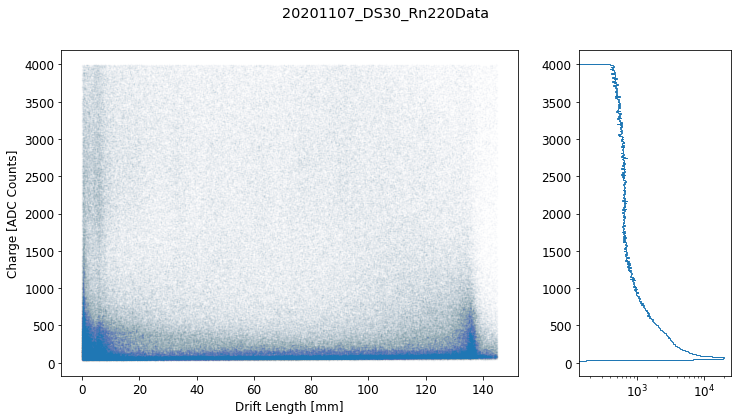

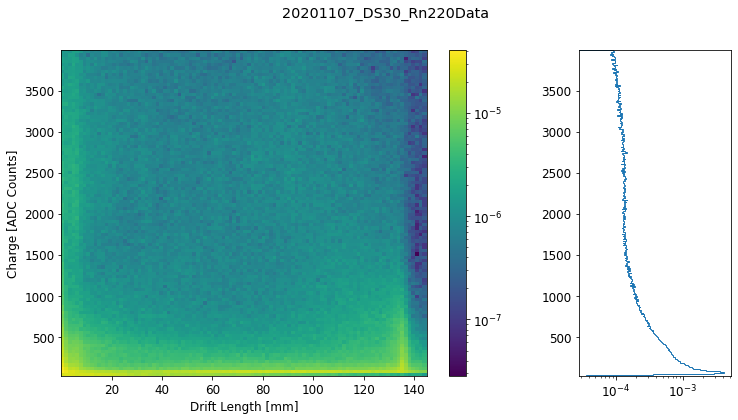

In [15]:
from matplotlib import gridspec
mask = (df['TotalTileEnergy']<4000) & (df['WeightedPosZ']<145) & (df['WeightedPosZ']>0)# & (df['TotalTileEnergy']>150)# & (df['NumberOfClusters']<3)
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharey=ax0)
ax0.scatter(df['WeightedPosZ'][mask], df['TotalTileEnergy'][mask],s=1,alpha=0.01)
#ax0.plot(x,630*np.exp(-x/60),c='red')
#ax0.plot(x,630*375/203*np.exp(-x/60),c='magenta')
ax1.hist( df['TotalTileEnergy'][mask],orientation="horizontal",bins=500,histtype='step',log=True)
#plt.title(folder.split('/')[0])
ax0.set_xlabel('Drift Length [mm]')
ax0.set_ylabel('Charge [ADC Counts]')
fig.suptitle(folder.split('/')[0])
plt.show()
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharey=ax0)
h_2d,x,y,im = ax0.hist2d(df['WeightedPosZ'][mask], df['TotalTileEnergy'][mask], bins=100, norm=LogNorm(),density=True)
#ax0.plot(x,630*np.exp(-x/60),c='red')
#ax0.plot(x,630*375/203*np.exp(-x/60),c='magenta')
h,b,_ = ax1.hist( df['TotalTileEnergy'][mask],orientation="horizontal",bins=500,histtype='step',log=True,density=True)
fig.colorbar(im,ax=ax0)
ax0.set_xlabel('Drift Length [mm]')
ax0.set_ylabel('Charge [ADC Counts]')
fig.suptitle(folder.split('/')[0])
plt.show()

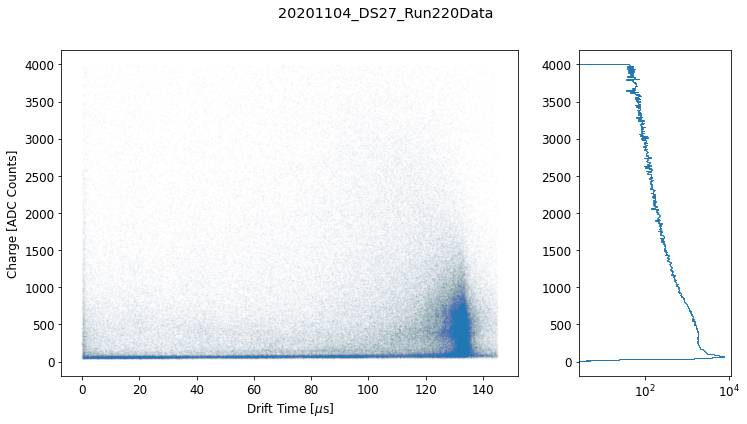

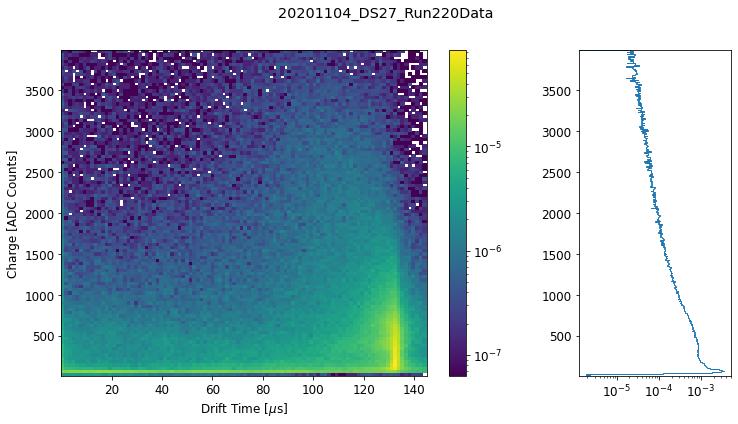

In [50]:
from matplotlib import gridspec
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
df['Purity-Corrected Charge Energy'] = df['TotalTileEnergy']*np.exp(DriftTime/55)
bipo_mask = ((df['SiPM 1-3 T20'] - df['SiPM 1-3 T5']) > 0.25/sampling_time) & (df['SiPM 1-3 Pulse Height']>500) & mask
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharey=ax0)
ax0.scatter(df['WeightedPosZ'][bipo_mask], df['TotalTileEnergy'][bipo_mask],s=1,alpha=0.01)
#ax0.plot(x,630*np.exp(-x/60),c='red')
#ax0.plot(x,630*375/203*np.exp(-x/60),c='magenta')
ax1.hist( df['TotalTileEnergy'][bipo_mask],orientation="horizontal",bins=500,histtype='step',log=True)
#plt.title(folder.split('/')[0])
ax0.set_xlabel('Drift Time [$\mu$s]')
ax0.set_ylabel('Charge [ADC Counts]')
fig.suptitle(folder.split('/')[0])
plt.show()
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharey=ax0)
h_2d,x,y,im = ax0.hist2d(df['WeightedPosZ'][bipo_mask], df['TotalTileEnergy'][bipo_mask], bins=100, norm=LogNorm(),density=True)
#ax0.plot(x,630*np.exp(-x/60),c='red')
#ax0.plot(x,630*375/203*np.exp(-x/60),c='magenta')
h,b,_ = ax1.hist( df['TotalTileEnergy'][bipo_mask],orientation="horizontal",bins=500,histtype='step',log=True,density=True)
fig.colorbar(im,ax=ax0)
ax0.set_xlabel('Drift Time [$\mu$s]')
ax0.set_ylabel('Charge [ADC Counts]')
fig.suptitle(folder.split('/')[0])
plt.show()

In [51]:
print(sum(bipo_mask)/len(df))

0.19497451624513348
